In [79]:
import os
import numpy as np  
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from collections import defaultdict

# 1. Read and explore the given dataset. (Rename column/add headers, plot histograms, find data characteristics)

In [2]:
ratings_data = pd.read_csv("ratings_Electronics.csv", names=["userId", "productId", "userRating", "timestamp"])

- Rename column/add headers

In [3]:
ratings_data.head()

,userId,productId,userRating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [4]:
#Dropping the timestamp column as it's not necessary
ratings_data.drop(['timestamp'],axis=1,inplace=True)

In [5]:
ratings_data.head()

,userId,productId,userRating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


### Find data characteristics

In [6]:
ratings_data.isna().apply(pd.value_counts)

,userId,productId,userRating
False,7824482,7824482,7824482


- No Null values

In [7]:
ratings_data['userId'].nunique() #unique user count

4201696

In [8]:
ratings_data['productId'].nunique() #unique product count

476002

In [9]:
ratings_data['userRating'].nunique() #unique ratings

5

### Plot histograms

(array([ 901765.,       0.,  456322.,       0.,       0.,  633073.,
              0., 1485781.,       0., 4347541.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <a list of 10 Patch objects>)

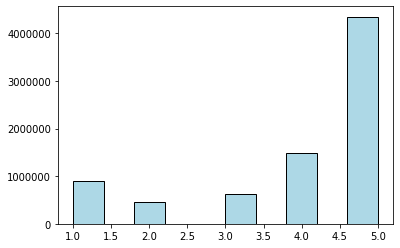

In [10]:
plt.hist(ratings_data.userRating, color='lightblue', edgecolor = 'black')

# 2. Take a subset of the dataset to make it less sparse/ denser. ( For example, keep the users only who has given 50 or more number of ratings )

In [11]:
userRating_count = ratings_data.groupby(["userId"])["userRating"].count()
userRating_count.head()

userId
A00000262KYZUE4J55XGL    1
A000063614T1OE0BUSKUT    2
A00009182QVLSWIGHLS1B    1
A00009661LC9LQPGKJ24G    1
A00010809P09NUU6ZP6H     1
Name: userRating, dtype: int64

In [12]:
userRating_df = pd.DataFrame(data=userRating_count)

In [13]:
userRating_df.rename(columns={"userRating": "userRatingCount"}, inplace = True)

In [14]:
userRating_df.head()

,userRatingCount
userId,
A00000262KYZUE4J55XGL,1
A000063614T1OE0BUSKUT,2
A00009182QVLSWIGHLS1B,1
A00009661LC9LQPGKJ24G,1
A00010809P09NUU6ZP6H,1


In [15]:
userRating_df.reset_index(inplace = True)

In [16]:
userRating_df.head()

,userId,userRatingCount
0,A00000262KYZUE4J55XGL,1
1,A000063614T1OE0BUSKUT,2
2,A00009182QVLSWIGHLS1B,1
3,A00009661LC9LQPGKJ24G,1
4,A00010809P09NUU6ZP6H,1


In [17]:
filter = userRating_df['userRatingCount'] >= 50

In [18]:
userRating_df.where(filter, inplace = True)

In [19]:
userRating_df.size

8403392

In [20]:
userRating_df.dropna(inplace = True)

In [21]:
userRating_df.shape

(1540, 2)

- Only 1540 users have rated for more than or equal to 50 products

In [22]:
userRating_df.head()

,userId,userRatingCount
5506,A100UD67AHFODS,116.0
5558,A100WO06OQR8BQ,132.0
9928,A105S56ODHGJEK,68.0
9965,A105TOJ6LTVMBG,71.0
13836,A10AFVU66A79Y1,65.0


In [23]:
df_final = pd.merge(ratings_data, userRating_df)

In [24]:
df_final.head()

,userId,productId,userRating,userRatingCount
0,A3BY5KCNQZXV5U,0594451647,5.0,50.0
1,A3BY5KCNQZXV5U,B00000JD4V,4.0,50.0
2,A3BY5KCNQZXV5U,B000063574,5.0,50.0
3,A3BY5KCNQZXV5U,B0000CDJP8,5.0,50.0
4,A3BY5KCNQZXV5U,B0007Y794O,5.0,50.0


In [25]:
df_final.shape

(125871, 4)

- Final dataset for building models

# 3. Split the data randomly into train and test dataset. ( For example, split it in 70/30 ratio)

In [56]:
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import train_test_split

In [59]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df_final[['userId', 'productId', 'userRating']], reader)

- Building the Dataset using surprise library

In [60]:
trainset, testset = train_test_split(data, test_size=.3)

- splitting the dataset into train and test into 70:30 

# 4. Build Popularity Recommender model.

In [33]:
df_final.groupby('productId')['userRating'].mean().sort_values(ascending=False).head()  

productId
B00LKG1MC8    5.0
B002QUZM3M    5.0
B002QWNZHU    5.0
B002QXZPFE    5.0
B002R0DWNS    5.0
Name: userRating, dtype: float64

In [34]:
df_final.groupby('productId')['userRating'].count().sort_values(ascending=False).head()  

productId
B0088CJT4U    206
B003ES5ZUU    184
B000N99BBC    167
B007WTAJTO    164
B00829TIEK    149
Name: userRating, dtype: int64

In [35]:
ratings_mean_count = pd.DataFrame(df_final.groupby('productId')['userRating'].mean()) 

In [36]:
ratings_mean_count['rating_counts'] = pd.DataFrame(df_final.groupby('productId')['userRating'].count())  

In [38]:
ratings_mean_count.sort_values(['rating_counts', 'userRating'], ascending=[False, False]).head()  

,userRating,rating_counts
productId,,
B0088CJT4U,4.218447,206
B003ES5ZUU,4.864130,184
B000N99BBC,4.772455,167
B007WTAJTO,4.701220,164
B00829TIEK,4.436242,149


- Deriving the top 5 popular products for the given dataset. It is derived using the products having maximum rated with maximum rates

# 5. Build Collaborative Filtering model.

- Train the Model
- Predict the test data
- Compute the error (RMSE)
- Recommend top - K ( K = 5) new products for each user based on his/her habits

###  User Based collaborative model using KNNWithMeans with 50 neighbours

In [73]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
algo = KNNWithMeans(k=50, sim_options={'name': 'pearson_baseline', 'user_based': True})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [62]:
test_pred = algo.test(testset)

In [63]:
test_pred

[Prediction(uid='A1URXSRV6WDHVY', iid='B001DKBNMA', r_ui=5.0, est=4.764245585874799, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid='A303SNZ4AR7TDQ', iid='B004GL4UZK', r_ui=5.0, est=4.15, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A1U11IP6K6NHAK', iid='B003YFE1H6', r_ui=5.0, est=4.261743976211283, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='ASF3J4UYV34KA', iid='B0012HNJEE', r_ui=5.0, est=4.261743976211283, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A2J8T58Z4X15IO', iid='B001MT8J4W', r_ui=5.0, est=4.333333333333333, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A24HWYHR28JJ7A', iid='B000T0C46Y', r_ui=4.0, est=4.5, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A213J54E63SYOP', iid='B002WGQJPA', r_ui=4.0, est=4.261743976211283, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 

In [69]:
# get RMSE
print("User-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

User-based Model : Test Set
RMSE: 1.0593


1.059335293018137

In [80]:
def get_top_n(predictions, n):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [89]:
UserKnn_top5 = get_top_n(test_pred, 5)

In [90]:
UserKnn_top5                 #Top 5 products for each user in test data

defaultdict(list,
            {'A1URXSRV6WDHVY': [('B00119T6NQ', 5),
              ('B00BWH7TIG', 5),
              ('B0052SCU8U', 5),
              ('B00I6CVPVC', 5),
              ('B001TH7GT6', 5)],
             'A303SNZ4AR7TDQ': [('B002C745WS', 4.261743976211283),
              ('B0087EVHVW', 4.261743976211283),
              ('B000RGG5EC', 4.261743976211283),
              ('B004GL4UZK', 4.15),
              ('B0009I4VE4', 4.15)],
             'A1U11IP6K6NHAK': [('B00CMJZAOI', 5),
              ('B00BB72WX4', 5),
              ('B00AIHYHJA', 4.997019926771596),
              ('B00AZW4MYI', 4.984016411973477),
              ('B00BA8596G', 4.923414274395208)],
             'ASF3J4UYV34KA': [('B00B9996LA', 4.548978153629316),
              ('B006WAGG14', 4.36060606060606),
              ('B0012HNJEE', 4.261743976211283),
              ('B000UTQOEW', 4.261743976211283),
              ('B0037FR47C', 4.261743976211283)],
             'A2J8T58Z4X15IO': [('B005KFONIU', 5),
              (

In [91]:
# Print the recommended items for each user
for uid, user_ratings in UserKnn_top5.items():
    print(uid, [iid for (iid, _) in user_ratings])

A1URXSRV6WDHVY ['B00119T6NQ', 'B00BWH7TIG', 'B0052SCU8U', 'B00I6CVPVC', 'B001TH7GT6']
A303SNZ4AR7TDQ ['B002C745WS', 'B0087EVHVW', 'B000RGG5EC', 'B004GL4UZK', 'B0009I4VE4']
A1U11IP6K6NHAK ['B00CMJZAOI', 'B00BB72WX4', 'B00AIHYHJA', 'B00AZW4MYI', 'B00BA8596G']
ASF3J4UYV34KA ['B00B9996LA', 'B006WAGG14', 'B0012HNJEE', 'B000UTQOEW', 'B0037FR47C']
A2J8T58Z4X15IO ['B005KFONIU', 'B00EVIBN8U', 'B00ATM1MVU', 'B00DQKQ7U8', 'B00871SR68']
A24HWYHR28JJ7A ['B004CLYEE6', 'B00AQRUW4Q', 'B0062XB9FE', 'B006ZT4VA0', 'B0067WUSGQ']
A213J54E63SYOP ['B002WGQJPA', 'B00B2AT8DW', 'B002OEBTCS', 'B00E5Z3R6A', 'B004MUCOBW']
A38QEATH3NODFM ['B000ELC148', 'B00000JF4L', 'B000288I4U', 'B000LD14PQ', 'B0009RGLSE']
A3TA1UJWRJF9NC ['B001B8EUEW', 'B0009YJXMS', 'B002JPITXY', 'B00005BC0J', 'B0001FTVDQ']
ASHJAZC9OA9NS ['B002RWJGHC', 'B001EDXPMC', 'B000TG4BA0', 'B001SERK28', 'B0083WYFWG']
A2ZFBTGPDP6PH6 ['B001TH7GUU', 'B004J3V90Y', 'B0011NVMO8', 'B0011YZJPA', 'B0007Y836W']
AT6CZDCP4TRGA ['B002JQNXZC', 'B0000659TZ', 'B004TFTE0O',

AX05DBU8IRUWY ['B00H6ZP5OS', 'B003ZBZ64Q', 'B00B9KOCYA', 'B00CUBMF8W', 'B00AYQ433U']
A1SDPA1J98UP4L ['B00EDIU5IW', 'B00D601UC8', 'B00022AVDM', 'B00B00TFK0', 'B003BEDRIO']
AROQO2VDODT7 ['B001F8SCRE', 'B000053HBB', 'B004J3Y9U6', 'B000I1X3W8', 'B00017LSPI']
A1BXVZSQOJE6UE ['B00A4LAZMS', 'B00BOE1HXA', 'B001FA1O18', 'B00IODWU6W', 'B003VANO7C']
A19FRW264WZTGP ['B00829THK0', 'B00HMREOLK', 'B00A81ICCE', 'B005DIQ2OC', 'B003ULNA3K']
A2SH6A32BE6NEV ['B001DJ64D4', 'B005NGOPSY', 'B00BZC31WQ', 'B008EQZ25K', 'B0081FLFQE']
A1BZIM4WGZ6DZP ['B00EZSUVHK', 'B0074BW614', 'B005F778JO', 'B000067SCY', 'B0057YRJNK']
A3V7D0LH8L7BG0 ['B00139JBU2', 'B00BOHNYTW', 'B001TANZ0W', 'B004ZP74IM', 'B0054CFKQI']
A1A535TCGNMVPI ['B00FFZD51Q', 'B000E0I9K4', 'B007L5NKZO', 'B003FVS8W8', 'B005INAVHQ']
A1QRST0A3IQIEF ['B000HKDA0U', 'B001TH7T2U', 'B00012F7HS', 'B007R67FNA', 'B004GLBI7S']
A11D1KHM7DVOQK ['B0000932AM', 'B000059L44', 'B00006JILW', 'B000063ENL', 'B0007M6104']
A2PICNZWHEINQC ['B0062EUE54', 'B005ES0YYA', 'B004LNXO28',

###  User Based collaborative model using Matrix factorization (SVD) method

In [66]:
from surprise import SVD
algo_1 = SVD()
algo_1.fit(trainset)

In [75]:
test_pred_1 = algo_1.test(testset)
test_pred_1

[Prediction(uid='A1URXSRV6WDHVY', iid='B001DKBNMA', r_ui=5.0, est=4.782792812896597, details={'was_impossible': False}),
 Prediction(uid='A303SNZ4AR7TDQ', iid='B004GL4UZK', r_ui=5.0, est=4.152610226129441, details={'was_impossible': False}),
 Prediction(uid='A1U11IP6K6NHAK', iid='B003YFE1H6', r_ui=5.0, est=4.479958922912065, details={'was_impossible': False}),
 Prediction(uid='ASF3J4UYV34KA', iid='B0012HNJEE', r_ui=5.0, est=4.080041698712878, details={'was_impossible': False}),
 Prediction(uid='A2J8T58Z4X15IO', iid='B001MT8J4W', r_ui=5.0, est=4.405908647597194, details={'was_impossible': False}),
 Prediction(uid='A24HWYHR28JJ7A', iid='B000T0C46Y', r_ui=4.0, est=4.478338703599609, details={'was_impossible': False}),
 Prediction(uid='A213J54E63SYOP', iid='B002WGQJPA', r_ui=4.0, est=3.7904184056391252, details={'was_impossible': False}),
 Prediction(uid='A38QEATH3NODFM', iid='B000ELC148', r_ui=5.0, est=4.724848909251041, details={'was_impossible': False}),
 Prediction(uid='A3TA1UJWRJF9NC'

In [76]:
# get RMSE
print("SVD Model : Test Set")
accuracy.rmse(test_pred_1, verbose=True)

SVD Model : Test Set
RMSE: 0.9822


0.9821916749759655

In [96]:
rmse_1 = accuracy.rmse(test_pred_1, verbose=True)

RMSE: 0.9822


In [86]:
SVD_top_n = get_top_n(test_pred_1, 5)

In [87]:
SVD_top_n

defaultdict(list,
            {'A1URXSRV6WDHVY': [('B0052SCU8U', 5),
              ('B0035FZ14M', 4.861334054991302),
              ('B00119T6NQ', 4.845271225797331),
              ('B00I6CVPVC', 4.80351432916857),
              ('B001DKBNMA', 4.782792812896597)],
             'A303SNZ4AR7TDQ': [('B007SZ0EOW', 4.5475112800831745),
              ('B004CRSM4I', 4.443448617441514),
              ('B0009I4VE4', 4.379771794397888),
              ('B0002SQ2P2', 4.325027914319739),
              ('B004GL4UZK', 4.152610226129441)],
             'A1U11IP6K6NHAK': [('B00CMJZAOI', 4.926545293288256),
              ('B004286VMW', 4.895228749863231),
              ('B00BB72WX4', 4.774474087234207),
              ('B00BB6DCUC', 4.68899577173587),
              ('B00AZW4MYI', 4.6308059355702476)],
             'ASF3J4UYV34KA': [('B001TH7GT6', 4.43586560245161),
              ('B0006HIMFM', 4.272828967091908),
              ('B006WAGG14', 4.140428877990104),
              ('B003YKG9D0', 4.128546036988

In [88]:
# Print top 5 recommended items for each user
for uid, user_ratings in SVD_top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

A1URXSRV6WDHVY ['B0052SCU8U', 'B0035FZ14M', 'B00119T6NQ', 'B00I6CVPVC', 'B001DKBNMA']
A303SNZ4AR7TDQ ['B007SZ0EOW', 'B004CRSM4I', 'B0009I4VE4', 'B0002SQ2P2', 'B004GL4UZK']
A1U11IP6K6NHAK ['B00CMJZAOI', 'B004286VMW', 'B00BB72WX4', 'B00BB6DCUC', 'B00AZW4MYI']
ASF3J4UYV34KA ['B001TH7GT6', 'B0006HIMFM', 'B006WAGG14', 'B003YKG9D0', 'B003MVMTDA']
A2J8T58Z4X15IO ['B00EVIBN8U', 'B00DQKQ7U8', 'B005KFONIU', 'B00BM1PWY0', 'B001NJ0WCS']
A24HWYHR28JJ7A ['B00BOHNYTW', 'B004CLYEDC', 'B0067WUSGQ', 'B000X06ZH4', 'B000EVSLRO']
A213J54E63SYOP ['B003NR57BY', 'B008ZGKWQI', 'B000FBK3QK', 'B005QWY3PU', 'B004AGXHE6']
A38QEATH3NODFM ['B000LD14PQ', 'B00142MUEM', 'B0009R5KQS', 'B00004TWM3', 'B000ELC148']
A3TA1UJWRJF9NC ['B0001FTVDQ', 'B003VGUGBS', 'B001157NBW', 'B001ZTHO36', 'B002JPITXY']
ASHJAZC9OA9NS ['B0049XGNKK', 'B001EDXPMC', 'B002RWJGHC', 'B006R38IJY', 'B000TG4BA0']
A2ZFBTGPDP6PH6 ['B001TH7GUU', 'B004WB8EYM', 'B001I45TA8', 'B004J3V90Y', 'B000EVSLRO']
AT6CZDCP4TRGA ['B001V9KG0I', 'B003D0ID8U', 'B002JQNXZC',

A1T7EHCMZ92TKC ['B005MI8NJA', 'B000EVOOO8', 'B005HMBQR2', 'B00EN27SHY', 'B000J5LA9Q']
A2TA40MV2H4O6F ['B001TH7GUU', 'B008AST7R6', 'B00BQ4F9ZA', 'B002V88HFE', 'B0012Y6HC8']
A386LG0LRWKJZP ['B00007M1TZ', 'B00299G80Q', 'B009SYZ8OC', 'B00F3KWZW8', 'B006K54ZU0']
ACP9S40H3SHY1 ['B005UVWEG2', 'B0090XWU8S', 'B00564GFFE', 'B0084FM5JC', 'B0043VE29C']
AV10H5K6VPQIJ ['B00316263Y', 'B00029U1DK', 'B000B9RI14', 'B005CLPP8E', 'B0001Y7UAI']
AT2J7H5TRZM8Z ['B00005LB8P', 'B000031KIM', 'B000065V15', 'B00000J4FS', 'B00005B0BY']
A2XAKGRUHIE2ZA ['B000XHS4SK', 'B0016LTZFI', 'B00D3F7D7M', 'B001F51G1Q', 'B001FA1NK0']
A3NCIN6TNL0MGA ['B005LS2GPI', 'B002RWJD98', 'B000MUXJCO', 'B00006HOLO', 'B003VANOI6']
A18L9A64XNGVGU ['B0052SCU8U', 'B001TH7T2U', 'B002RM08RE', 'B003NZSX7G', 'B00DY7VAL4']
AYCAIHABPYWVJ ['B000XRW09Y', 'B0092JBV8A', 'B0047T6PH2', 'B002NTMHJI', 'B0014E7NEM']
A3JU990UTN5RQP ['B002YU83YO', 'B008F537KC', 'B00083LFW6', 'B004RKQMCY', 'B0028N78C0']
A3JU16JTNLVK1J ['B00AANQLRI', 'B00007B4DM', 'B00004ZCB4', 

- SVD has RMSE value less tha KNNMeans, which is why SVD can be considered more accurate

In [ ]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
item_algo = KNNWithMeans(k=50, sim_options={'name': 'pearson_baseline', 'user_based': False})
item_algo.fit(trainset)

In [ ]:
item_test_pred = item_algo.test(testset)
item_test_pred

- Item Item collaborative filtering failed due to memory error in jupyter notebook as well as Google colab

# 8. Summarise your insights.

In [101]:
from surprise import SVDpp
from surprise import SlopeOne
from surprise import NMF
from surprise import NormalPredictor
from surprise import KNNBaseline
from surprise import KNNBasic
from surprise import KNNWithZScore
from surprise import BaselineOnly
from surprise import CoClustering
from sklearn.model_selection import cross_validate

In [114]:
tmp = pd.DataFrame({'Collaborative Filter':[],'RMSE':[]})
# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    # Perform cross validation
    # results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    test_pred = algo.fit(trainset).test(testset)
    test_rmse = accuracy.rmse(test_pred, verbose=True)
        
    tmp = tmp.append(pd.Series({'Collaborative Filter':str(algorithm).split(' ')[0].split('.')[-1] , 'RMSE':test_rmse}), ignore_index=True)

RMSE: 0.9829
RMSE: 0.9815
RMSE: 0.9825
RMSE: 0.9818
RMSE: 0.9820
RMSE: 0.9824
RMSE: 0.9812
RMSE: 0.9805
RMSE: 0.9818
RMSE: 0.9814
RMSE: 0.9815


In [117]:
tmp.sort_values(['RMSE'], ascending=True)

,Collaborative Filter,RMSE
7,KNNWithMeans,0.980474
6,KNNBasic,0.981245
9,BaselineOnly,0.981393
10,CoClustering,0.981469
1,SVDpp,0.981473
8,KNNWithZScore,0.981784
3,NMF,0.981784
4,NormalPredictor,0.982034
5,KNNBaseline,0.982397
2,SlopeOne,0.982473


- The RMSE is lowest for KNNWithMeans with default neighbor as 40. Thus this is the most trustworthy user-based recommender model for predicting the test data.

- In Popularity Recommender model, top 5 will be same for all users as it is not a personalised model.

- Popularity Recommender model can customized in various ways accordingly.